# Ticketklassifikation mit BERT

Orientierungsquelle: https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613

### Benötigte Pakete importieren

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json
import IProgress
import random
import time

import torch
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
import torch.nn as nn

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import f1_score

### Ticketdaten importieren, betrachten und splitten

In [2]:
ticket_df = pd.read_excel('tickets_cleaned.xlsx')
ticket_df.head()

,Unnamed: 0,Ticket-ID,Datum,Stichwort,Meldung,Ticketart,Sprache,Stichwort_cleaned,Meldung_cleaned,Meldung_BERT,Länge,Stichwort_lemmatized,Meldung_lemmatized,Klasse
0,0,TN-2302-00013,2023-02-01 00:00:00,[Ext.] #207695: Wave sehr langsam: Einzelfall?,"Hallo Herr Willi, _x000D__x000D_wir bekommen v...",Support,de,Ext Wave langsam Einzelfall,Hallo Herr Willi bekommen Kollegen beinahe tae...,Hallo Herr Willi wir bekommen von einem Kolleg...,136,Ext Wave langsam Einzelfall,Hallo Herr Willi bekommen Kollege beinahe taeg...,2
1,1,TN-2302-00016,2023-02-01 00:00:00,Per E-Mail senden: license.lhlic,könnt Ihr bitte meine deltaCAD-Demodatenbank-...,Lizenz,de,Per Mail senden license lhlic,koennt Ihr bitte deltaCAD Demodatenbank Lizenz...,koennt Ihr bitte meine deltaCAD Demodatenbank ...,10,per Mail send license Lhlic,koennen ihr bitte deltaCAD Demodatenbank Lizen...,4
2,2,TN-2302-00017,2023-02-01 00:00:00,Bestellung eines Headsets,"Hallo Zusammen,_x000D_\n_x000D_\nich habe aktu...",IT,de,Bestellung Headsets,Hallo Zusammen aktuell probleme Senheiser Head...,Hallo Zusammen ich habe aktuell probleme mit m...,44,Bestellung Headset,Hallo zusammen aktuell problem Senheiser Heads...,3
3,3,TN-2302-00018,2023-02-01 00:00:00,Online Package Repo - Changelog und Release Datum,Im Package Repo fehlt leider die Möglichkeit d...,Wunsch,de,Online Package Repo Changelog Release Datum,Im Package Repo fehlt leider Moeglichkeit dire...,Im Package Repo fehlt leider die Moeglichkeit ...,78,Online Package Repo Changelog Release Datum,in Package Repo fehlen leider Moeglichkeit dir...,1
4,4,TN-2302-00021,2023-02-01 00:00:00,Waveabsturz: Message => Object reference not s...,Wenn man auf einer Tätigkeit steht und auf die...,Bug,de,Waveabsturz Message Object reference not set t...,Wenn Taetigkeit steht neue Funktion Vorgaenge ...,Wenn man auf einer Taetigkeit steht und auf di...,31,Waveabsturz Message Object reference not set t...,wenn Taetigkeit stehen neu Funktion Vorgaeng k...,0


In [3]:
X_train, X_val, y_train, y_val = train_test_split(ticket_df.index.values, ticket_df.Klasse.values, test_size=0.15, random_state=24, stratify=ticket_df.Klasse.values)

ticket_df['data_type'] = ['not_set']*ticket_df.shape[0]

ticket_df.loc[X_train, 'data_type'] = 'train'
ticket_df.loc[X_val, 'data_type'] = 'val'

### BERT-Tokenizer importieren und Ticketmeldungen kodieren

In [4]:
tokenizer = BertTokenizer.from_pretrained('dbmdz/bert-base-german-cased', do_lower_case=False)
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-german-cased', do_lower_case=False)

In [5]:
ticket_df = ticket_df[ticket_df.Meldung_BERT.notna()]

In [6]:
encoded_data_train = tokenizer.batch_encode_plus(
    ticket_df[ticket_df.data_type=='train'].Meldung_BERT.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    ticket_df[ticket_df.data_type=='val'].Meldung_BERT.values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(ticket_df[ticket_df.data_type=='train'].Klasse.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(ticket_df[ticket_df.data_type=='val'].Klasse.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


### BERT-Modell und Adam-Optimierer laden

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained('dbmdz/bert-base-german-cased', num_labels=6, output_attentions=False, output_hidden_states=False)
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-german-cased', num_labels=6, output_attentions=False, output_hidden_states=False)
model.to(device)

Some weights of the model checkpoint at dbmdz/bert-base-german-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dbmdz/bert-base-german-cased and are newly initi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31102, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [8]:
batch_size = 3

dataloader_train = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch_size)
dataloader_validation = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch_size)

In [9]:
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8)
epochs = 6
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Evaluierungsfunktionen definieren

In [10]:
label_dict = {'Bug': 0, 'Wunsch': 1, 'Support': 2, 'IT': 3, 'Lizenz': 4, 'Sonstiges': 5}

In [11]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [12]:
seed_val = 24
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [13]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    correct_predictions = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
        
        preds = np.argmax(logits, axis=1)
        correct_predictions += np.sum(preds == label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    validation_accuracy = correct_predictions/len(dataloader_val.dataset)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals, validation_accuracy

In [14]:
def evaluate_classification_report(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.extend(np.argmax(logits, axis=1))
        true_vals.extend(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    classification_report_output = classification_report(true_vals, predictions, output_dict=True)
    confusion_matrix_output = confusion_matrix(true_vals, predictions)
    balanced_accuracy = balanced_accuracy_score(true_vals, predictions)
            
    return loss_val_avg, classification_report_output, confusion_matrix_output, balanced_accuracy

### Verlustfunktion anpassen

In [15]:
labels_train_numpy = labels_train.cpu().numpy()
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_train_numpy), y=labels_train_numpy)
weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

loss_fn = nn.CrossEntropyLoss(weight=weights)

### Trainingsschleife

In [16]:
loss_values = []
accuracy_values = []
training_times = []

for epoch in tqdm(range(1, epochs+1)):
    
    start_time_bert = time.time()
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = loss_fn(outputs[1], inputs['labels']) # mit Anpassung der Gewichte in Verlust-Funktion: 
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model') # statt torch.save(model.state_dict(), f'data_volume/finetuned_BERT_epoch_{epoch}.model')
    # torch.save(model.state_dict(), f'finetuned_DistilBERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals, val_accuracy = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    
    loss_values.append(round(val_loss, 3))
    accuracy_values.append(round(val_accuracy, 3))
    
    end_time_bert = time.time()

    training_times.append(end_time_bert - start_time_bert)

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/12313 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.8967348664688205
Validation loss: 0.7988242025518091
F1 Score (Weighted): 0.7567225992470825


Epoch 2:   0%|          | 0/12313 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.7663590102912036
Validation loss: 0.9212734339095058
F1 Score (Weighted): 0.7742262115661658


Epoch 3:   0%|          | 0/12313 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.6539091113041042
Validation loss: 1.0170176923888812
F1 Score (Weighted): 0.778331804564521


Epoch 4:   0%|          | 0/12313 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.514492635396704
Validation loss: 1.1886973989258964
F1 Score (Weighted): 0.7824567750240381


Epoch 5:   0%|          | 0/12313 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.3883100877966155
Validation loss: 1.349926188373572
F1 Score (Weighted): 0.7777949102745975


Epoch 6:   0%|          | 0/12313 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.2889148611638058
Validation loss: 1.460090504059297
F1 Score (Weighted): 0.7742135782535052


### Val.verlust und Val.genauigkeit im Trainingsprozess beobachten

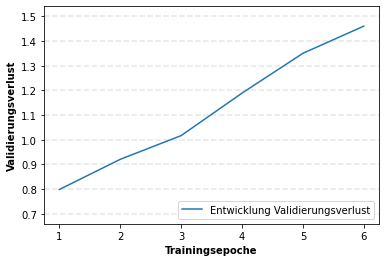

In [30]:
fig, ax = plt.subplots()
ax.plot(range(1, epochs+1), loss_values, label='Entwicklung Validierungsverlust')
ax.set_xlabel('Trainingsepoche', fontweight='bold')
ax.set_ylabel('Validierungsverlust', fontweight='bold')
ax.legend(loc='lower right')

plt.xticks(range(1, epochs+1))

for y in ax.yaxis.get_ticklocs():
    ax.axhline(y, color='gray', alpha=0.2, linestyle='--')

plt.savefig('pictures/bert_val_loss.png', dpi=600)    
plt.show()

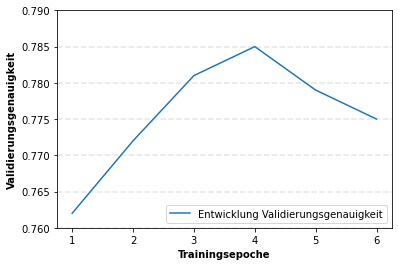

In [31]:
fig, ax = plt.subplots()
ax.plot(range(1, epochs+1), accuracy_values, label='Entwicklung Validierungsgenauigkeit')
ax.set_xlabel('Trainingsepoche', fontweight='bold')
ax.set_ylabel('Validierungsgenauigkeit', fontweight='bold')
ax.legend(loc='lower right')

plt.yticks(ax.get_yticks(), [f'{val:.3f}' for val in ax.get_yticks()])
plt.xticks(range(1, epochs+1))

for y in ax.yaxis.get_ticklocs():
    ax.axhline(y, color='gray', alpha=0.2, linestyle='--')

plt.savefig('pictures/bert_val_accuracy.png', dpi=600)
plt.show()

### Bestes Modell laden und evaluieren

In [19]:
model = BertForSequenceClassification.from_pretrained('dbmdz/bert-base-german-uncased', num_labels=6, output_attentions=False, output_hidden_states=False)
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-german-cased', num_labels=6, output_attentions=False, output_hidden_states=False)
model.to(device)

model.load_state_dict(torch.load('finetuned_BERT_epoch_4.model', map_location=torch.device('cuda')))
# model.load_state_dict(torch.load('finetuned_DistilBERT_epoch_4.model', map_location=torch.device('cuda')))

_, predictions, true_vals, val_accuracy = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Some weights of the model checkpoint at dbmdz/bert-base-german-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

Class: Bug
Accuracy: 2096/2455

Class: Wunsch
Accuracy: 1221/1634

Class: Support
Accuracy: 572/1012

Class: IT
Accuracy: 635/679

Class: Lizenz
Accuracy: 196/288

Class: Sonstiges
Accuracy: 395/451



In [20]:
model = BertForSequenceClassification.from_pretrained('dbmdz/bert-base-german-uncased', num_labels=6, output_attentions=False, output_hidden_states=False)
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-german-cased', num_labels=6, output_attentions=False, output_hidden_states=False)
model.to(device)

model.load_state_dict(torch.load('finetuned_BERT_epoch_4.model', map_location=torch.device('cuda')))
# model.load_state_dict(torch.load('finetuned_DistilBERT_epoch_4.model', map_location=torch.device('cuda')))

loss_val_avg, classification_report_output, confusion_matrix_output, balanced_accuracy = evaluate_classification_report(dataloader_validation)

Some weights of the model checkpoint at dbmdz/bert-base-german-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

In [21]:
training_time_bert = 0
for i in range(3):
    training_time_bert += training_times[i]

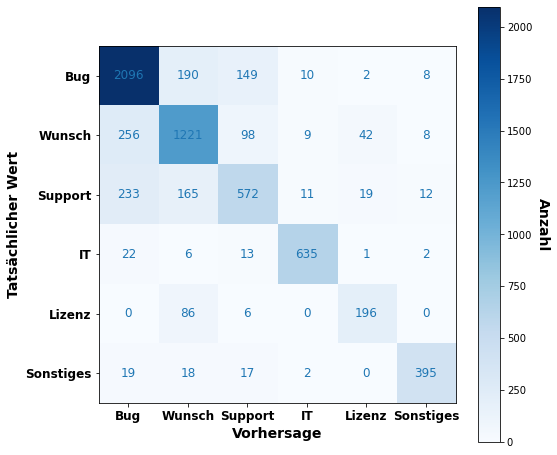

In [32]:
classes = ['Bug', 'Wunsch', 'Support', 'IT', 'Lizenz', 'Sonstiges']

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(confusion_matrix_output, cmap=plt.cm.get_cmap('Blues'))

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, fontsize=12, fontweight='bold')
ax.set_yticklabels(classes, fontsize=12, fontweight='bold')

for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, confusion_matrix_output[i, j], ha='center', va='center', color='#1f77b4', fontsize=12)


plt.xlabel('Vorhersage', fontsize=14, fontweight='bold')
plt.ylabel('Tatsächlicher Wert', fontsize=14, fontweight='bold')

legend_bar = ax.figure.colorbar(im, ax=ax)
legend_bar.ax.set_ylabel("Anzahl", rotation=-90, va="bottom", fontsize=14, fontweight='bold')

plt.savefig('pictures/bert_conf_matrix.png', dpi=600)
plt.show()

### Evaluierungswerte des BERT-Modells zwischenspeichern

In [29]:
bert_values = {
    "training_time_bert": training_time_bert,
    "accuracy_bert": classification_report_output['accuracy'],
    "balanced_accuracy_bert": balanced_accuracy,
    "f1_score_macro_bert": classification_report_output['macro avg']['f1-score'],
    "f1_score_weighted_bert": classification_report_output['weighted avg']['f1-score']
}

json_bert = json.dumps(bert_values)
    
with open('value_cache_bert', 'w') as f:
    f.write(json_bert)